# Viviendas Leon 

### Who are we? 

We are Berkeley undergraduates working with Viviendas Leon, a nonprofit dedicated to eliminating rural poverty in Nicaragua and Guatemala. 

`Team lead`: Elda Pere

`Team members`: Lauren Faulds, Chase Elements, Barnett (Adam) Yang, Kathryn (Katie) Byers, Eva Sidlo, Kelly Trinh 


### Questions to address: 
Given location, soil, and weather data, which crops should a farmer plant that would be most resilient to disease?

### Dataset description: 
`Data source`: Viviendas Leon 

It contains information on crop disease percentage, crop conditions, and any recommendations made. We also scraped weather data, which includes dew point, temperature, percipitation data, and more, and append to our dataset. 
 
### Objectives: 
1. Clean the data to account for missing value, inconsistent names, translate Spanish to English, and scrap weather data to supplement the dataset. 
2. Perform exploratory data analysis to find trends between crop type, effectiveness of recommendations, and geographical area, and disease percentage.
3. Build a classifier to predict which crop is most disease-resilient given specific weather and geographical information. 

`Note`: The initial data cleaning step is left in the appendix below for brevity. The original data is in Spanish, therefore, some of the table showed below will be in Spanish.




### Import Libraries

In [38]:
!brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
ddcctl
==> Updated Formulae
Updated 21 formulae.

==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/12.0.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:fe1e5c0fa8f
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring libomp--12.0.0.big_sur.bottle.tar.gz
🍺  /usr/local/Cellar/libomp/12.0.0: 9 files, 1.5MB


In [168]:
import pandas as pd
import numpy as np
!pip install sklearn
import sklearn 
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import svm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
!pip install xgboost
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN
df

,Region,Crop,Seedling_or_transplanted,% Disease,Condition,Plague,Organic recommendation,Chemical recommendation,Type,Month visited,...,Location_12.46%-86.95,Location_12.46%-86.96,Location_12.46%-87.0,Location_12.47%-86.95,Location_12.48%-86.95,Location_12.48%-86.96,Trans_or_seed_0,Trans_or_seed_7.082352941,Trans_or_seed_seedling,Trans_or_seed_transplanted
0,Troilo,Calala,transplanted,3,good_cond,0,0,0,Fruit,11,...,0,0,1,0,0,0,0,0,0,1
1,Troilo,Papaya,transplanted,2,good_cond,0,0,0,Fruit,11,...,0,0,1,0,0,0,0,0,0,1
2,Troilo,Calala,transplanted,3,good_cond,0,0,0,Fruit,11,...,0,0,0,0,0,0,0,0,0,1
3,Troilo,Papaya,transplanted,2,good_cond,0,0,0,Fruit,11,...,0,0,0,0,0,0,0,0,0,1
4,Troilo,Calala,transplanted,2,good_cond,0,0,0,Fruit,11,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6742,Goyena,Maiz,transplanted,0,excellent_cond,0,0,0,Grains,10,...,0,0,0,0,1,0,0,0,0,1
6743,Troilo,Maiz,transplanted,0,excellent_cond,0,0,0,Grains,10,...,0,1,0,0,0,0,0,0,0,1
6744,Troilo,Maiz,transplanted,0,excellent_cond,0,0,0,Grains,10,...,0,0,1,0,0,0,0,0,0,1
6745,Goyena,Maiz,transplanted,2,good_cond,Deafania,Hojas de chile,0,Grains,10,...,0,0,0,0,1,0,0,0,0,1


### 👀 Read Data

`VL_farm_geo_w.csv` is the dataset that went through initial cleaning. 

Each row represents a visit from Viviendas Leon to a family. The row has information on the crop (condition, percent disease, type of crop, and weather conditions such as dew point, heat index, etc.


The data spans from 2017 to 2021. 



In [6]:
# connect to the drive
drive.mount('/content/gdrive')
path = "/content/gdrive"
chases_path = path + "/MyDrive"
kellys_path = path + "/MyDrive/VL_Data/Farming_Data"
os.chdir(kellys_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [176]:
#df = pd.read_csv('/content/gdrive/MyDrive/VL_farm.csv') # read Kelly and Lauren's updated data

df= pd.read_csv('VL_farm_geo_w.csv', index_col=0)


# translate Spanish to English
def season(month):
    if month == 12 or month == 1 or month == 2:
        return "Winter"
    elif month == 3 or month == 4 or month == 5:
        return "Spring"
    elif month == 6 or month == 7 or month == 8:
        return "Summer"
    elif month == 9 or month == 10 or month == 11:
        return "Fall"
df["Season visited"] = df["Month visited"].apply(season)


df['Condition'] = df['Condition'].replace(['Excel'], 'Excelente')
df['Condition'] = df['Condition'].replace(['Excelente'], "excellent_cond")
df['Condition'] = df['Condition'].replace(['Promedio'], 'average_cond')
df['Condition'] = df['Condition'].replace(['Bueno'], 'good_cond')
df['Condition'] = df['Condition'].replace(['Pobre'], 'poor_cond')
df['Condition'] = df['Condition'].replace(['crisopa'], 'bad?_cond')

df['Condition'] = df['Condition'].replace([0], 'N/A_cond')
df['Seedling_or_transplanted'].unique()
df['Seedling_or_transplanted'] = df['Seedling_or_transplanted'].replace(['Almácigo'], 'seedling')
df['Seedling_or_transplanted'] = df['Seedling_or_transplanted'].replace(['Transplantado'], 'transplanted')
df['Seedling_or_transplanted'] = df['Seedling_or_transplanted'].replace(['Sin germinar'], 'transplanted')
df['Seedling_or_transplanted'] = df['Seedling_or_transplanted'].replace(['Fructificacion'], 'fruitification')
df['Seedling_or_transplanted'] = df['Seedling_or_transplanted'].replace(['Produccion'], 'production')
df

#drop rows with unsual values 
df = df[df.Condition != 'bad?_cond']
df = df[df['Seedling_or_transplanted'] != 'fruitification']
df = df[df['Seedling_or_transplanted'] != 'production']


# 'Bueno'== good, '0'== null, 'Promedio'==average, 'Excelente'==excellent, 'Pobre'==poor, 'Excel', 'crisopa'

# preview of the data
hide_location = (df.columns != "Region") & (df.columns != "Community") & (df.columns != "location") & (df.columns != "longitude") & (df.columns !="latitude")
df.loc[0:5, hide_location]

,Date visited,Auditor,Family visited,Present?,Crop,Seedling_or_transplanted,% Disease,Condition,Plague,Organic recommendation,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Season visited
0,2017-11-06,Lesbia/Camilo,karla galiano martínez,Si,Calala,transplanted,3,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall
1,2017-11-06,Lesbia/Camilo,karla galiano martínez,Si,Papaya,transplanted,2,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall
2,2017-11-06,Lesbia/Camilo,claudia flavia arévalo,Si,Calala,transplanted,3,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall
3,2017-11-06,Lesbia/Camilo,cristina alvares solís,Si,Papaya,transplanted,2,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall
4,2017-11-06,Lesbia/Camilo,cristina alvares solís,Si,Calala,transplanted,2,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall
5,2017-11-06,Lesbia/Camilo,ana catalina garcía millón,Si,Papaya,transplanted,1,good_cond,0,0,...,9,18,82,5.3,1013,31,9,105,5,Fall


In [177]:
df.shape

(6741, 45)

### Data Preview

Looking at ordinal variable Crop Condition and % Illness

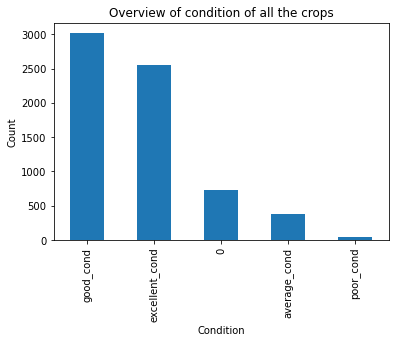

In [178]:

# 0 = No entry 

df['Condition'].value_counts().plot(kind='bar')
plt.title("Overview of condition of all the crops")
plt.ylabel("Count")
plt.xlabel("Condition");

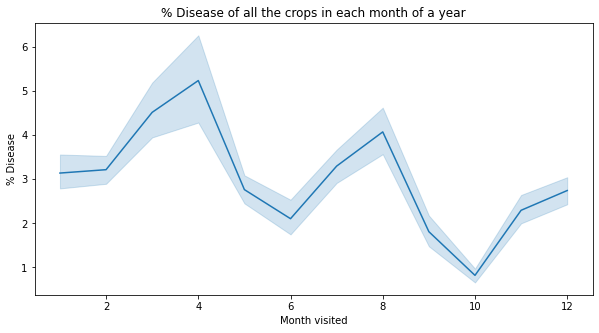

In [179]:
plt.figure(figsize=(10,5))

dsh = sns.lineplot(x="Month visited", y="% Disease"
             ,data=df)
plt.title("% Disease of all the crops in each month of a year");

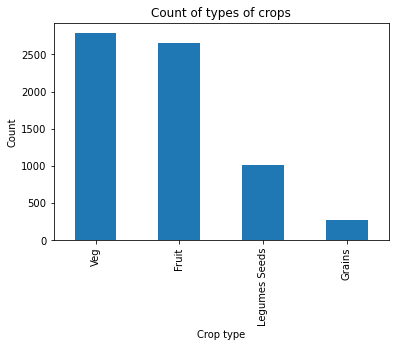

In [180]:
plt.title("Count of types of crops")
plt.xlabel("Crop type")
plt.ylabel("Count")
df['Type'].value_counts().plot(kind='bar');

Crops to predict:  42


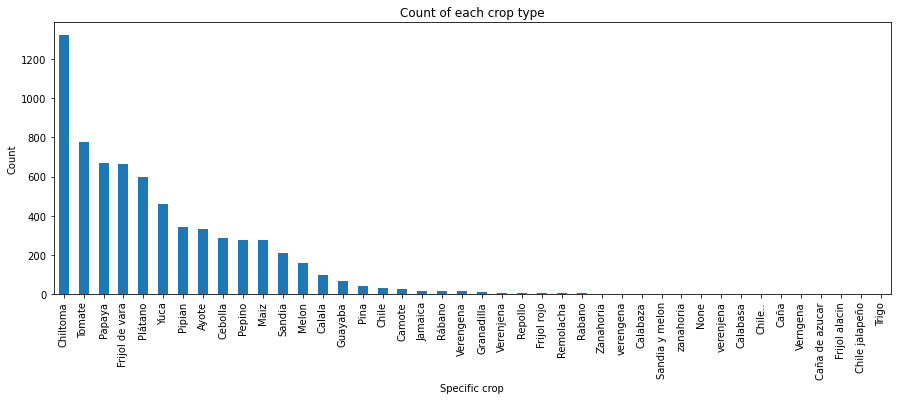

In [181]:
plt.figure(figsize=(15, 5))
plt.title("Count of each crop type")
plt.xlabel("Specific crop")
plt.ylabel("Count")
ax = df['Crop'].value_counts().plot(kind='bar')
#ax.set_xticks(df['Crop'].value_counts().values)
;
print('Crops to predict: ' , df['Crop'].nunique())

## ⚙️ Feature Engineering

This step determines which variables are not relevant for the model (using correlations, interview with staff, etc).




### Add Additional Variables

In [182]:
# Combined Wellness metric using % Illness and Condition

def condition_percentage (row):
   if row['Condition'] == 'excellent_cond' :
      return 1
   if row['Condition'] == 'good_cond' :
      return .90
   if row['Condition'] == 'average_cond':
      return .80
   if row['Condition']  == 'poor_cond':
      return .70
   if row['Condition'] == '0':
      return 1
   return .80

def condition_wellness_columns(df):
    df['Percent_Condition'] = df.apply(lambda row: condition_percentage(row), axis=1)
    df['Percent_wellness'] = 100 - df['% Disease']
    df['Wellness_Condition'] = df['Percent_wellness'] * df['Percent_Condition']
    return df

In [183]:
df = condition_wellness_columns(df)

In [184]:
df['Crop'] = df['Crop'].replace(['Calabasa'], 'Calabaza')
df['Crop'] = df['Crop'].replace(['verengena', 'verenjena'], 'bad?_cond')

In [185]:
# For each crop, 
df1 = df[['Region', 'Crop']]
df1.groupby(['Crop']).count()

,Region
Crop,
Ayote,331
Calabaza,2
Calala,100
Camote,28
Caña,1
Caña de azucar,1
Cebolla,284
Chile,33
Chile jalapeño,1


In [186]:
# drop crops with only 1 count
df1 = df1.drop(df1.index[[4173, 5141, 2249, 6539, 4317, 3817, 6403, 5476, 311, 6697, 3002, 2908, 4494]])

### Scoring System

In [187]:
class ScoreResult:
    def __init__(
        self, 
        comp_scores, 
        cond_scores, 
        per_dis_scores, 
        reg_cond_scores, 
        reg_per_dis_scores, 
        com_cond_scores, 
        com_per_dis_scores,
        type_comp_scores,
        type_cond_scores,
        type_per_dis_scores,
        type_reg_cond_scores,
        type_reg_per_dis_scores,
        type_com_cond_scores,
        type_com_per_dis_scores,
        crops,
        types
    ):
        self.comp_scores = comp_scores
        self.cond_scores = cond_scores
        self.per_dis_scores = per_dis_scores
        self.reg_cond_scores = reg_cond_scores
        self.reg_dis_scores = reg_per_dis_scores
        self.com_cond_scores = com_cond_scores
        self.com_dis_scores = com_per_dis_scores
        self.type_comp_scores = type_comp_scores
        self.type_cond_scores = type_cond_scores
        self.type_per_dis_scores = type_per_dis_scores
        self.type_reg_cond_scores = type_reg_cond_scores
        self.type_reg_dis_scores = type_reg_per_dis_scores
        self.type_com_cond_scores = type_com_cond_scores
        self.type_com_dis_scores = type_com_per_dis_scores
        self.crops = crops
        self.types = types
        
    def get_best_composite(self, n=None):
        if n == None:
            n = len(self.crops)
        crops = self.crops.copy()
        crops.sort(key=lambda x: -self.comp_scores[x])
        return crops[:n]
    
    def get_best_region(self, n=None):
        if n == None:
            n = len(self.crops)
        crops = self.crops.copy()
        crops.sort(key=lambda x: -(self.reg_cond_scores[x] + self.reg_dis_scores[x]))
        return crops[:n]
    
    def get_best_community(self, n=None):
        if n == None:
            n = len(self.crops)
        crops = self.crops.copy()
        crops.sort(key=lambda x: -(self.com_cond_scores[x] + self.com_dis_scores[x]))
        return crops[:n]
    
    def get_best_type_composite(self, n=None):
        if n == None:
            n = len(self.types)
        types = self.types.copy()
        types.sort(key=lambda x: -self.type_comp_scores[x])
        return types[:n]
    
    def get_best_type_region(self, n=None):
        if n == None:
            n = len(self.types)
        types = self.types.copy()
        types.sort(key=lambda x: -(self.type_reg_cond_scores[x] + self.type_reg_dis_scores[x]))
        return types[:n]
    
    def get_best_type_community(self, n=None):
        if n == None:
            n = len(self.types)
        types = self.types.copy()
        types.sort(key=lambda x: -(self.type_com_cond_scores[x] + self.type_com_dis_scores[x]))
        return types[:n]
        
def normalize(d, target=1.0):
    raw = sum(d.values())
    factor = target/raw
    return {key:value*factor for key,value in d.items()}

def init_score(df,  
               crops=None, 
               types=None, 
               regions=None, 
               communities=None, 
               conds = None,
               cond_weights={
                   "good_cond": 1, 
                   "Bueno" : 1,
                   "excellent_cond": 2, 
                   "Excelente": 2,
                   "Excel": 2,
                   "average_cond": -1, 
                   "Promedio": -1,
                   "poor_cond": -2, 
                   "Pobre": -2,
                   "crisopa": -2,
                   0: 0, 
                   '0': 0}):
    if crops == None:
        crops = list(df["Crop"].unique())
    if regions == None:
        regions = list(df["Region"].unique())
    if types == None:
        types = list(df["Type"].unique())
    if communities == None:
        communities = list(df["Community"].unique())
    if conds == None:
        conds = list(df["Condition"].unique())
        
        
    def score(region=None, community=None):
        if region != None and region not in regions:
            raise ValueError(f"region is not valid, valid inputs include: {', '.join(regions)}")
        if community != None and community not in communities:
            raise ValueError(f"community is not valid, valid inputs include: {', '.join(communities)}")
        
        comp_scores = dict.fromkeys(crops, 0)
        cond_scores = dict.fromkeys(crops, 0)
        per_dis_scores = dict.fromkeys(crops, 0)
        
        reg_cond_scores = dict.fromkeys(crops, 0)
        reg_per_dis_scores = dict.fromkeys(crops, 0)
        
        com_cond_scores = dict.fromkeys(crops, 0)
        com_per_dis_scores = dict.fromkeys(crops, 0)
        
        for crop in crops:
            cond_total = 0
            n = 0
            crop_df = df[df["Crop"] == crop]
            cond_counts = crop_df["Condition"].value_counts().to_dict()
            for cond in conds:
                if cond in cond_counts:
                    cond_total += cond_counts[cond] * cond_weights[cond]
                    n += cond_counts[cond]
            if n == 0:
                cond_scores[crop] = 0
            else:
                cond_scores[crop] = cond_total / n
            per_dis_scores[crop] = 100 - crop_df["% Disease"].mean()
        cond_scores = normalize(cond_scores)
        per_dis_scores = normalize(per_dis_scores)
        
        if region != None:
            region_df = df[df["Region"] == region]
            for crop in crops:
                cond_total = 0
                n = 0
                crop_df = region_df[region_df["Crop"] == crop]
                cond_counts = crop_df["Condition"].value_counts().to_dict()
                for cond in conds:
                    if cond in cond_counts:
                        cond_total += cond_counts[cond] * cond_weights[cond]
                        n += cond_counts[cond]
                if n == 0:
                    reg_cond_scores[crop] = 0
                else:
                    reg_cond_scores[crop] = cond_total / n
                if isinstance(100 - crop_df["% Disease"].mean(), np.float64):
                    reg_per_dis_scores[crop] = 100 - crop_df["% Disease"].mean()
                else:
                    reg_per_dis_scores[crop] = 0
            reg_cond_scores = normalize(reg_cond_scores)
            reg_per_dis_scores = normalize(reg_per_dis_scores)
                
        if community != None:
            com_df = df[df["Community"] == community]
            for crop in crops:
                cond_total = 0
                n = 0
                crop_df = com_df[com_df["Crop"] == crop]
                cond_counts = crop_df["Condition"].value_counts().to_dict()
                for cond in conds:
                    if cond in cond_counts:
                        cond_total += cond_counts[cond] * cond_weights[cond]
                        n += cond_counts[cond]
                if n == 0:
                    com_cond_scores[crop] = 0
                else:
                    com_cond_scores[crop] = cond_total / n
                if isinstance(100 - crop_df["% Disease"].mean(), np.float64):
                    com_per_dis_scores[crop] = 100 - crop_df["% Disease"].mean()
                else:
                    com_per_dis_scores[crop] = 0
            com_cond_scores = normalize(com_cond_scores)
            com_per_dis_scores = normalize(com_per_dis_scores)
        
        for crop in crops:
            comp_scores[crop] += cond_scores[crop] + per_dis_scores[crop]
            if region != None:
                comp_scores[crop] += reg_cond_scores[crop] + reg_per_dis_scores[crop]
            if community != None:
                comp_scores[crop] += com_cond_scores[crop] + com_per_dis_scores[crop]
        comp_scores = normalize(comp_scores)
        
        
        type_comp_scores = dict.fromkeys(types, 0)
        type_cond_scores = dict.fromkeys(types, 0)
        type_per_dis_scores = dict.fromkeys(types, 0)
        
        type_reg_cond_scores = dict.fromkeys(types, 0)
        type_reg_per_dis_scores = dict.fromkeys(types, 0)
        
        type_com_cond_scores = dict.fromkeys(types, 0)
        type_com_per_dis_scores = dict.fromkeys(types, 0)
        
        for _type in types:
            cond_total = 0
            n = 0
            type_df = df[df["Type"] == _type]
            cond_counts = type_df["Condition"].value_counts().to_dict()
            for cond in conds:
                if cond in cond_counts:
                    cond_total += cond_counts[cond] * cond_weights[cond]
                    n += cond_counts[cond]
            if n == 0:
                type_cond_scores[_type] = 0
            else:
                type_cond_scores[_type] = cond_total / n
            type_per_dis_scores[_type] = 100 - type_df["% Disease"].mean()
        type_cond_scores = normalize(type_cond_scores)
        type_per_dis_scores = normalize(type_per_dis_scores)
        
        if region != None:
            region_df = df[df["Region"] == region]
            for _type in types:
                cond_total = 0
                n = 0
                type_df = region_df[region_df["Type"] == _type]
                cond_counts = type_df["Condition"].value_counts().to_dict()
                for cond in conds:
                    if cond in cond_counts:
                        cond_total += cond_counts[cond] * cond_weights[cond]
                        n += cond_counts[cond]
                if n == 0:
                    type_reg_cond_scores[_type] = 0
                else:
                    type_reg_cond_scores[_type] = cond_total / n
                if isinstance(100 - type_df["% Disease"].mean(), np.float64):
                    type_reg_per_dis_scores[_type] = 100 - type_df["% Disease"].mean()
                else:
                    type_reg_per_dis_scores[_type] = 0
            type_reg_cond_scores = normalize(type_reg_cond_scores)
            type_reg_per_dis_scores = normalize(type_reg_per_dis_scores)
                
        if community != None:
            com_df = df[df["Community"] == community]
            for _type in types:
                cond_total = 0
                n = 0
                type_df = com_df[com_df["Type"] == _type]
                cond_counts = type_df["Condition"].value_counts().to_dict()
                for cond in conds:
                    if cond in cond_counts:
                        cond_total += cond_counts[cond] * cond_weights[cond]
                        n += cond_counts[cond]
                if n == 0:
                    type_com_cond_scores[_type] = 0
                else:
                    type_com_cond_scores[_type] = cond_total / n
                if isinstance(100 - type_df["% Disease"].mean(), np.float64):
                    type_com_per_dis_scores[_type] = 100 - type_df["% Disease"].mean()
                else:
                    type_com_per_dis_scores[_type] = 0
            type_com_cond_scores = normalize(type_com_cond_scores)
            type_com_per_dis_scores = normalize(type_com_per_dis_scores)
        
        for _type in types:
            type_comp_scores[_type] += type_cond_scores[_type] + type_per_dis_scores[_type]
            if region != None:
                type_comp_scores[_type] += type_reg_cond_scores[_type] + type_reg_per_dis_scores[_type]
            if community != None:
                type_comp_scores[_type] += type_com_cond_scores[_type] + type_com_per_dis_scores[_type]
        type_comp_scores = normalize(type_comp_scores)
        
        return ScoreResult(
            comp_scores, 
            cond_scores, 
            per_dis_scores, 
            reg_cond_scores, 
            reg_per_dis_scores, 
            com_cond_scores, 
            com_per_dis_scores,
            type_comp_scores,
            type_cond_scores,
            type_per_dis_scores,
            type_reg_cond_scores,
            type_reg_per_dis_scores,
            type_com_cond_scores,
            type_com_per_dis_scores,
            crops,
            types
        )
    
    return score

## 🔥 Modeling

Leads: Adam & Chase

#### Multiclass Classification 
Predicts crops with highest probability of success given features. Highest probability of success is defined by the observations of wellness metrics in crops given specific features. Preference for crops that have a higher wellness score are suitable for the season and location.

##### Feature Columns Used Include:
Predictors of interest are `Season`, `DewPointC`, `HeatIndexC`, `Region`

Metrics 
- Weight on the features for the either the quality or illness
- Make list from outputs, then aggregate lists

- Composite score: 
  - average quality , average percent disease
    - When modeling can get rid of crops with illness, bad quality 
  - Model that maps crops to expected percent disease , maps other conditions conditions with season and location ( average percent disease in different locations ) 

Tasks 
- Model for specific crop, output top 5 crops
- Tune parameters in `xgboost`, possibly use gridsearch
- Seedling based predictions
- Predictions for 3 months down the line


### Pipeline for training, cross validation and test sets


In [188]:
# Drop unneeded columns
drop_cols = ["Date visited", "Auditor", "Family visited", "Present?",
             "apienter", "date_time", "Community", "Year visited",
             "moonrise", "moonset", "sunrise", "sunset"]
df = df.drop(drop_cols, axis = 1)

df.head(1)

,Region,Crop,Seedling_or_transplanted,% Disease,Condition,Plague,Organic recommendation,Chemical recommendation,Type,Month visited,...,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,Season visited,Percent_Condition,Percent_wellness,Wellness_Condition
0,Troilo,Calala,transplanted,3,good_cond,0,0,0,Fruit,11,...,1013,31,9,105,5,12.46%-87.0,Fall,0.9,97,87.3


In [189]:
# One hot encoding

# Questions for Elda:
# Multiple spellings of same crop name
# Should we drop "Plague"? Has 162 different unique values. 1-hot encode for now. Ask team as well
# Should we drop organic and chemical recommendations? Has a lot of 0 values. First pass: include them (1-hot encode)
# Keep "Community" or "location"? 1-hot encode either? Keep location (1-hot encode), drop "Community"
# Keep condition and percent diseased? Keep these.

df = df.join(pd.get_dummies(df["Season visited"], prefix="Season"), how = 'outer')
df = df.join(pd.get_dummies(df["Condition"], prefix="Condition"), how = 'outer')
df = df.join(pd.get_dummies(df["Region"], prefix="Region"), how= 'outer')
# df = df.join(pd.get_dummies(df["Plague"], prefix="Plague"), how= 'outer')
df = df.join(pd.get_dummies(df["location"], prefix="Location"), how = "outer")
df = df.join(pd.get_dummies(df["Seedling_or_transplanted"], prefix="Trans_or_seed"), how = "outer")
# df = df.join(pd.get_dummies(df["Organic recommendation"], prefix="Org_rec"), how = "outer")
# df = df.join(pd.get_dummies(df["Chemical recommendation"], prefix="Chem_rec"), how = "outer")

# Drop now one-hot encoded columns
# df = df.drop(["Season visited", "Condition", "Region", "Plague", "location", "Seedling_or_transplanted", "Organic recommendation", "Chemical recommendation"], axis = 1)

In [190]:
# Split into training and testing sets and Oversample using SMOTE 
y = df[["Crop"]].copy()
X = df.drop(["Crop"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Evaluating Based on Quality

### Training the Model

##### Featue Columns Used Include:
Predictors of interest include:
  - Weather: `DewPointC`, `HeatIndexC`, `WindChillC`, `sunHour`
  - Season: `Season_Fall`, `Season_Spring`, `Season_Summer`, `Season_Winter`, `Month Visited`(?)
  - Location Based: `Region_Goyena`, `Region_Troilo`, Location binary?

In [191]:
predictors = df[['% Disease', 'Wellness_Condition', 'HeatIndexC', 'DewPointC', 'WindChillC', 'sunHour', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Region_Goyena', 'Region_Troilo']]
target = df['Type']

In [192]:
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight


In [193]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, shuffle=True)

# data normalization using MinMaxScaler (standardscaler decreases accuracy due to nongaussian distribution)
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

kf = KFold(n_splits=5, random_state=42)

classes = np.unique(target)


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

### Evaluation

In [194]:
#roc curves, confusion matrixes using cross validation and training sets

In [195]:
# Checking for America's Next Top Models
# cv_results = {}
# result_table = pd.DataFrame(columns=['classifiers', 'accuracy'])

models = {'xgboost': XGBClassifier(random_state=42,),
        'logistic regression': LogisticRegression(solver="lbfgs", random_state=42, multi_class="multinomial"),
        'KNN': KNeighborsClassifier( n_neighbors=5),
        'decision tree': DecisionTreeClassifier(random_state=42),
        'random forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'SVC': svm.SVC(random_state=42),
        'one vs rest': OneVsRestClassifier(SVC(random_state=42)) }

for model in models.items():
  for train_ind, val_ind in kf.split(X_train_norm, y_train):
    X_tr, y_tr = X_train_norm[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train_norm[val_ind], y_train.iloc[val_ind]
    #fit model in dictionary with values
    model[1].fit(X_tr, y_tr)
    #predict
    y_pred = model[1].predict(X_val)

  #testing metrics
    precision = precision_score(y_val, y_pred, average='weighted')
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    # cv_results[model[0]] = (accuracy)
    cm = confusion_matrix(y_val,y_pred)

  #roc auc scores
  for each in classes:
      fpr, tpr, thresholds = roc_curve(y_val,  
                      model[1].predict_proba(X_val)[:,1], pos_label = each) 

      auroc = round(metrics.auc(fpr, tpr),2)
      print(each,'--AUC--->',auroc)

  print(model[0], '\n', 'accuracy score:', accuracy, '\n', 'f1 score: ', f1, '\n precision: ', precision)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation
  # labels, title and ticks
  ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Fruit', 'Grains', 'Legumes', 'Veg']); ax.yaxis.set_ticklabels(['Fruit', 'Grains', 'Legumes', 'Veg']);
  plt.show()      
  print('\n') 


NameError: name 'kf' is not defined

#### Model Comparison

In [196]:
# XGBoost
!pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train.values.ravel())

y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

[12:44:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/eva/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/eva/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.43439584877687176

In [197]:
# XGBoost with tuned parameters
# {'gamma': 1, 'learn_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}
tuned_xgboost_model = XGBClassifier(gamma=1, learn_rate=0.1, max_depth=3, subsample=0.9)
tuned_xgboost_model.fit(X_train, y_train.values.ravel())

y_pred = tuned_xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/eva/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.4425500370644922

In [198]:
# K Nearest Neighbors
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.values.ravel())

y_pred = neighbors.predict(X_test)
accuracy_score(y_test, y_pred)

0.4158636026686434

In [199]:
# Decision Trees
DT_clf = DecisionTreeClassifier()
DT_clf.fit(X_train, y_train.values.ravel())

y_pred = DT_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.41808747220163084

In [200]:
# Support Vector Classifier
SVC = svm.SVC()
SVC.fit(X_train, y_train)

y_pred = SVC.predict(X_test)
accuracy_score(y_test, y_pred)

0.4395848776871757

### Hyperparameter Tuning

In [201]:
class_weight = compute_class_weight('balanced', classes, target)
print(class_weight)

NameError: name 'classes' is not defined

In [ ]:
# Finding the best parameters for XGBoost
def parameter_tune(clf, hyper_params):
    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(clf, hyper_params, scoring=acc_scorer)
    grid_obj.fit(X_train, y_train)
    return grid_obj

# Parameter combonations that the grid search will try
hyper_params = {'max_depth': [3, 4, 5],
                'learn_rate': [0.1, 0.09, 0.08, 0.07],
                'subsample': [0.8, 0.9, 1],
                'gamma': [0, 1, 5]}
# Find the best parameters with GridSearchCV
#grid_search_obj = parameter_tune(XGBClassifier(), hyper_params)
#grid_search_obj.cv_results_

In [ ]:
# Make the results into a dataframe
#grid_search_df = pd.DataFrame(grid_search_obj.cv_results_)
#grid_search_df

In [ ]:
# Print out the best parameters
#grid_search_obj.best_params_

In [ ]:
# Get the best estimator
#BEST_XG_CLF = grid_search_obj.best_estimator_
#BEST_XG_CLF

In [ ]:
# Print the classification_report of the best estimator
#BEST_XG_CLF.fit(X_train, y_train)

#y_pred = BEST_XG_CLF.predict(X_test)
#accuracy_score(y_test, y_pred)

#print(classification_report(y_test, y_pred))

In [ ]:
# XGBoost with oversampled data
# over sampled train set
!pip install RandomOverSampler
import RandomOverSampler
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train_norm, y_train)


xgboost_model_o = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=1, gamma=0, learn_rate=0.2,
                    learning_rate=0.1, max_delta_step=0, max_depth=3,
                    min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                    nthread=None, objective='multi:softprob', random_state=42,
                    reg_alpha=0, reg_lambda=1, sample_rate=0.8,
                    seed=None, silent=None, subsample=1, verbosity=1)
xgboost_model_o.fit(X_train_over, y_train_over)

y_pred = xgboost_model_o.predict(X_test_norm)
accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

In [ ]:
predictors = df[['% Disease', 'Wellness_Condition', 'HeatIndexC', 'DewPointC', 'WindChillC', 'sunHour', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Region_Goyena', 'Region_Troilo']]
targetc = df['Crop']

X_trainc, X_testc, y_trainc, y_testc = train_test_split(predictors, targetc, test_size=0.2, shuffle=True)

In [ ]:
# Crops data 
!pip install XGBClassifier
xgboost_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=1, gamma=0, learn_rate=0.2,
                    learning_rate=0.1, max_delta_step=0, max_depth=3,
                    min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                    nthread=None, objective='multi:softprob', random_state=42,
                    reg_alpha=0, reg_lambda=1, sample_rate=0.8, scale_pos_weight=class_weight,
                    seed=None, silent=None, subsample=1, verbosity=1)
xgboost_model.fit(X_trainc, y_trainc)

y_pred = xgboost_model.predict(X_testc)
accuracy_score(y_testc, y_pred)

print(classification_report(y_testc, y_pred))

## ➡️ Test set predictions

In [ ]:


def show_preds(df, X, y, clf, occupations, duplicates=False):
    df = df.copy()
    df["pred"] = [occupations[code] for code in clf.predict(X)]
    df["proba"] = clf.predict_proba(X).max(axis=1)
    df["correct"] = df["pred"] == df["occupation"]
    if not duplicates:
        df = df.drop_duplicates()
    acc = accuracy_score(df["occupation"], df["pred"])
    pred_df = df[["correct", "occupation", "pred", "proba", "jobtitle", "industry"]]
    out = pred_df.style.apply(lambda row: [
        "background: mediumspringgreen;" if row["pred"] is row["occupation"] else "background: tomato;" for cell in row
    ], axis=1, subset=["occupation", "pred"])
    print("Accuracy = {:.3f}".format(acc))
    return out


def show_weights(model, features, classes, ax=None):
    has_plot = True
    if ax is None:
        _, ax = plt.subplots(1, 1)
        has_plot = False
    weights = np.hstack([clf.intercept_.reshape(-1, 1), clf.coef_]).T
    classes = [occupations[crop] for crop in clf.classes_]
    predictors = ["intercept"] + features
    class_labels = ["\n".join(c.split(" ")) for c in classes]
    sns.heatmap(weights, annot=True, fmt=".3f", cmap="RdBu", ax=ax)
    ax.set_xticks(np.arange(len(classes)) + 0.5)
    ax.set_yticks(np.arange(len(predictors)) + 0.5)
    ax.set_xticklabels(class_labels, {"rotation": 0})
    ax.set_yticklabels(predictors, {"rotation": 0})
    ax.set_xlabel("Target Class")
    ax.set_ylabel("Predictor Variable")
    ax.set_title("Model Weights")
    if not has_plot:
        plt.show()

In [202]:
weights = np.hstack([clf.intercept_.reshape(-1, 1), clf.coef_]).T

NameError: name 'clf' is not defined

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:53300/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


ModuleNotFoundError: ignored

#### Prediction Visualizations

In [ ]:
###

### Appendix

#### Initial data cleaning 

We produced a cleaned version of the data titled `VL_farm_geo_w.csv`.
Below is a description of the initial data cleaning steps we took. 

The data we received from Viviendas Leon (VL) originally consisted of these files:

1) corrected names of farmers VL worked with

2) farming data 2017 - 2021 of the farmers 

3) coordinates of the families

We further scraped weather information to add to our analysis. 

1) replaced all the family names with corrected names

2) translated Spanish (the original language of the data) into English

3) merged the farming data with weather and geocoordinate data

Below are useful functions we used for data cleaning, and the code of our data cleaning.



### Read the Data

Files used for this Classifier:

- vl_2017to19.xlsx *from farming data folder* : Viviendas Leon visit data 2017 - 2019. Combine with vl_2019to20.xlsx for full dataset

- vl_2019to20.xlsxz *from farming data folder* : Viviendas Leon visit data 2019 - 2020

- 210304_Full Participant List Farming Program 2017-2021.xlsx *from farming data folder* : List of corrected family names.

- vl_historical_data.csv *from geo data folder*: 2017 - 2021 Weather Data for GPS locations to 2 decimal precision 

- family_coordinates_api.csv *located in geo data golder* : List of VL family names and api coordinates. Mergess Viviendas Leon visit data with historical weather data


## ✏️ Data Preparation

Leads: Lauren & Kelly

In [ ]:
# Load farming data, weather data, geo data

# dropped last three rows (just empty)
correct_names = pd.read_excel("210304_Full Participant List Farming Program 2017-2021.xlsx").drop([51,52,53], axis=0)
correct_names.columns = correct_names.loc[0,:]
correct_names = correct_names.drop([0], axis=0)

# load data
data_17_19 = pd.read_excel("VL Huertos Familiares- Hoja de Datos (2017-2019).xlsx")
data_19_20 = pd.read_excel("VL Huertos Familiares- Hoja de Datos (2019-2020).xlsx")

# Lauren
historic_w = pd.read_csv('w_historic.csv')
families_coordinates = pd.read_csv('family_coordinates_api.csv')

In [ ]:
def combined_farming(dataframe1, dataframe2):
  # Kelly
  #drop empty column
  dataframe1 = dataframe1.drop("Unnamed: 10", axis=1)

  '''Translate Spanish column names into English'''

  translated_cols = ['Date visited','Auditor','Region','Community','Family visited','Present?',
                      'Fruit','Fruit_Condition (seedling or transplanted)', 'Fruit_% Disease','Fruit_Condition',
                      'Fruit_Plague','Fruit_Organic recommendation','Fruit_Chemical recommendation',
                      'Vegetables','Veg_Condition (seedling or transplanted)','Veg_% Disease','Veg_Condition',
                      'Veg_Plague','Veg_Organic recommendation','Veg_Chemical recommendation',
                      'Legumes and seeds','LnS_Condition (seedling or transplanted)','LnS_% Disease',
                      'LnS_Condition','LnS_Plague','LnS_Organic recommendation','LnS_Chemical recommendation',
                      'Grasses','Grasses_Condition (seedling or transplanted)','Grasses_% Disease',
                      'Grasses_Condition','Grasses_Plague','Grasses_Organic recommendation',
                      'Grasses_Chemical recommendation',
                      'Commentaries, additional remarks','Response, commentary follow up']
  # rename columns 
  dataframe1.columns = translated_cols
  dataframe2.columns = translated_cols

  # drop first 3 rows (headings of table names)
  dataframe1 = dataframe1.drop([0, 1, 2], axis=0) 
  dataframe2 = dataframe2.drop([0, 1, 2], axis=0)

  # appending 2019-2020 to the bottom of 2017-2019 data
  combined_data = dataframe1.append(dataframe2)

  return combined_data

def clean_farming(combined_data):

  '''Preliminary cleaning for consistent data entry, correct names, and structuring
  data so that each row is one observation for one crop.'''

    # fill NaN with 0s
    combined_data = combined_data.fillna(0)


    # further cleaning
    combined_data["Month visited"] = combined_data["Date visited"].dt.month
    combined_data["Year visited"] = combined_data["Date visited"].dt.year
    combined_data["Veg_% Disease"] = combined_data["Veg_% Disease"].replace(['35 %', ';4', ' '], [35, 4, 0])
    combined_data["Fruit"] = combined_data["Fruit"].replace(['Piña', 'piña'], 'Pina')
    combined_data["Legumes and seeds"] = combined_data["Legumes and seeds"].replace("Pipián", "Pipian")
    combined_data["Legumes and seeds"] = combined_data["Legumes and seeds"].replace("I", "None")
    combined_data["Legumes and seeds"] = combined_data["Legumes and seeds"].replace(["Frijol Rojo", "Frijoles rojo"], "Frijol rojo")
    combined_data["Legumes and seeds"] = combined_data["Legumes and seeds"].replace(["Frijoles blanco", "Frijol blanco"])

    # replace with corrected names
    combined_data = combined_data.replace(correct_names.iloc[:,3].values, correct_names.iloc[:,4].values)

    # structure data so that one row is one observation 
    overall_info = combined_data.iloc[:,:6]
    fruit = combined_data.iloc[:,6:13]
    veg = combined_data.iloc[:,13:20]
    lns = combined_data.iloc[:,20:27]
    grasses = combined_data.iloc[:,27:34]

    # keeping a column for crop type
    fruit['Type'] = 'Fruit'
    veg['Type'] = 'Veg'
    lns['Type'] = 'Legumes Seeds'
    grasses['Type'] = 'Grains'

    crops = [fruit, veg, lns, grasses]
    crops_0 = []
    new_col_names = ['Date visited','Auditor','Region','Community','Family visited','Present?',
                          'Crop','Seedling_or_transplanted', '% Disease','Condition',
                          'Plague','Organic recommendation','Chemical recommendation', 'Type']

    for table in crops:
      temp = pd.concat([overall_info, table], axis=1)
      temp.columns = new_col_names
      crops_0.append(temp)

    final = crops_0[0]
    for table in crops_0[1:]:
      final = pd.concat([final, table], axis=0)

    # Lauren
    # Removing empties
    final = final[final['Crop']!=0]

    # Cleaning names column

    final['Family visited'] = final['Family visited'].str.lower()

    final = final.replace(
        ['arelis', 'arelis  solis', 'arelis solis',
          'arelis soliz', 'areliz solis', 'arlelis solis'], 'arelis solis')

    final = final.replace(
        ['freddy', 'freddy lanza', 'freddy lanzas',
          'freddy lasza', 'freddys campo', 'fredi ', 'fredis ',
          'fredis lanza', 'fredy lanzas', 'fredys'], 'freddy lanza')

    final = final.replace(
        ['helen espinoza', 'hellen', 'hellen espinoza', ], 'hellen espinoza')

    final = final.replace(
        ['johana', 'johana  salgado','johana salgado', 'johanna salgado', 'yohana salgado'], 'johana salgado')

    final = final.replace(
        ['juan sandobal', 'juan sandoval'], 'juan sandoval')

    final = final.replace(
        ['maria jose', 'maria jose roque',
          'maria jose roque ', 'mariajose roque', ',maria jose roque', ], 'maria jose roque')

    final = final.replace(
        ['marvin toval', 'marvin toval padilla'], 'marvin toval padilla')

    final = final.replace(
        ['naideling', 'naideling vargas', 'naidelyn', 'naidelyn vargas', 'naidelyng', 'naidelyng ', 'naidelyng vargas', 'naydelin', 'naydelin varga', 'naydeling', 'naydeling varga', 'naydeling vargas', 'nayeling varga’, ‘neilyng', 'ávila vargas'
    ], 'naydeling vargas')

    final = final.replace(
        ['nayeli roque','nayelis  roque', 'nayelis roque', 'nayelis roqur', 'nerlyn roque',
    ], 'nayelis roque')

    final = final.replace(
        ['nerligh hernandez', 'nerling henandez', 'nerling hernandez',
          'nerlyn hernandez', 'nerlynh hernandez',], 'nerling hernandez')

    final = final.replace(
        ['rayson membreño', 'reison membreño', 'reison membreńo',
          'reysom membreño', 'reyson membrecho', 'reyson membreño',
          'reyson membreńo', 'reyson menbreño'], 'reysom membreño')

    final = final.replace(
        ['yader  morales', 'yader morales', 'yader morales ',
          'yadermorales', ], 'yader morales')

    final["Month visited"] = final["Date visited"].dt.month
    final["Year visited"] = final["Date visited"].dt.year      
    return final


def clean_gps(families_coordinates):
    '''Making families_coordinates names identical to VL farming names'''

    families_coordinates['Name'] = families_coordinates['Name'].str[8:].str.lower()

    families_coordinates['Name'] = families_coordinates['Name'].str.replace('\s{2,}', ' ')
    families_coordinates = families_coordinates.replace(
        ['rebeca sequeira'], 'rebeca carolina sequeira morales')
    families_coordinates = families_coordinates.replace(
        ['fátima castillo'], 'maría de fátima castillo')
    families_coordinates = families_coordinates.replace(
        ['yojhana cristina flores'], 'johana cristina altamirano flores')
    families_coordinates = families_coordinates.replace(
        ['karla galeano'], 'karla galiano martínez')
    families_coordinates = families_coordinates.replace(
        ['rita arevalo'], 'rita arévalo mora')
    families_coordinates = families_coordinates.replace(
        ['cristina alvares'], 'cristina alvares solís')
    families_coordinates = families_coordinates.replace(
        ['claudia arevalo'], 'claudia flavia arévalo')
    families_coordinates = families_coordinates.replace(
        ['silvia elena  moran'], 'silvia elena moran')
    families_coordinates = families_coordinates.replace(
        ['cristina avendaño'], 'maria cristina avendaño')
    families_coordinates = families_coordinates.replace(
        ['melania jacaba quiroz'], 'melania jocoba quiroz')
    families_coordinates = families_coordinates.replace(
        ['daisy ramirez'], 'maria deisy ramirez')
    families_coordinates = families_coordinates.replace(
        ['maria eugenia morales'], 'maría eugenia morales')
    families_coordinates = families_coordinates.replace(
        ['ana catalina millón'], 'ana catalina garcía millón')
    families_coordinates = families_coordinates.replace(
        ['oralia ramimez'], 'oralia ramirez')
    families_coordinates = families_coordinates.replace(
        ['roosvelt donaire'], 'roosevelt donaire')

    return families_coordinates

def merged_unified(farming, families_coordinates, historic_w):
    '''
    takes farming dataset, family_coordinates, historic weather
    '''

    # Merge geolocation on family names
    geo_farm = pd.merge(farming, families_coordinates[['Name', 'apienter', 'latitude', 'longitude']], 
                                  how="left", left_on="Family visited", 
                                  right_on="Name").drop(columns=['Name'])

    # For missing locations, average longitude 12.46 and avg latitude: -86.96 are imputed                               
    geo_farm['apienter'].fillna('12.46%-86.96', inplace=True)

    
    historic_w['date_time'] = pd.to_datetime(historic_w.date_time)

    # Merge weather on geolocation
    final = pd.merge(geo_farm, historic_w,
                        how="left", left_on=["Date visited", "apienter"],
                        right_on=["date_time", "location"])
    
    # Last column addition
    final["Month visited"] = final["Date visited"].dt.month
    final["Year visited"] = final["Date visited"].dt.year
    
    return final

In [131]:
# this cell runs all the defined functions to clean the data

combined_data = combined_farming(data_17_19,data_19_20)
combined_data = clean_farming(combined_data)
families_coordinates = clean_gps(families_coordinates)

# Check Farming Dataset names against Correct Name List
# extra_names = [name for name in final["Family visited"].unique() if name not in correct_names.iloc[:,3].unique()]
# extra_names.sort()

# Check Family Coordinates names against Farming Dataset names
# [name for name in families_coordinates["Name"].unique() if name not in final["Family visited"].unique()]

final = merged_unified(combined_data, families_coordinates, historic_w)
# Write to CSV
# final.to_csv('VL_farm_geo_w.csv')
# final.to_csv("/content/drive/MyDrive/VL_farm.csv")

df


NameError: name 'combined_farming' is not defined

In [ ]:
import pickle 
import pandas as pd  #Pandas for data pre-processing
import joblib
import pickle #Pickle for pickling (saving) the model 

from sklearn.feature_extraction.text import CountVectorizer #To Vectorize the textual data 

from sklearn.naive_bayes import MultinomialNB #The algorithm for prediction 

 #Alternative Usage of Saved Model 

from sklearn.model_selection import train_test_split #Validation split
filename = 'finalized_model2.sav'
pickle.dump(SVC, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, y_train)
print(result)

cv = CountVectorizer() 


joblib.dump(SVC, 'NB_spam_model.pkl') 
joblib.dump(cv, 'cv.pkl')

import pickle
with open('farm_model_xgboost.pkl', 'wb') as file:
    pickle.dump(SVC, file)
    
import flask
app = flask.Flask(__name__, template_folder='templates')
@app.route('/', methods=['GET', 'POST'])
def main():
    if flask.request.method == 'GET':
        return(flask.render_template('main.html'))
    if flask.request.method == 'POST':
        temperature = flask.request.form['% Disease']
        humidity = flask.request.form['Wellness_Condition']
        windspeed = flask.request.form['HeatIndexC']
        x1 = flask.request.form['DewPointC']
        x2 = flask.request.form['WindChillC']
        x3 = flask.request.form['Season_Fall']
        x4 = flask.request.form['Season_Spring']
        x5 = flask.request.form['Season_Summer']
        x6 = flask.request.form['Season_Winter']
        x7 = flask.request.form['Region_Goyena']
        x8 = flask.request.form['Region_Troilo']
        
        input_variables = pd.DataFrame([[temperature, humidity, windspeed]],
                                       columns=['% Disease', 'Wellness_Condition', 'HeatIndexC','DewPointC', 
                                                'WindChillC', 'sunHour', 'Season_Fall', 'Season_Spring', 
                                                'Season_Summer', 'Season_Winter', 'Region_Goyena', 
                                                'Region_Troilo'],
                                       dtype=float)
        prediction = model.predict(input_variables)[0]
        return flask.render_template('main.html',
                                     original_input={'% Disease': Disease,
                                                     'Wellness_Condition':Wellness_Condition,
                                                     'Region_Troilo':Region_Troilo},
                                     result=prediction,
                                     )
if __name__ == '__main__':
    app.run()

0.47125370919881304
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


127.0.0.1 - - [07/May/2021 16:31:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/May/2021 16:31:00] "GET /favicon.ico HTTP/1.1" 404 -


In [220]:
from flask import Flask, render_template, request
app = Flask(__name__) 

@app.route('/') #Routes the app to below task when the URL is called 

def home(): 

    return render_template('main.html')
def predict_fun(): 

    NB_spam_model = open('NB_spam_model.pkl','rb') 
    clf = joblib.load(NB_spam_model)
    cv_model = open('cv.pkl', 'rb')
    cv = joblib.load(cv_model)
    if request.method == 'POST': 

        message = request.form['message'] 
        data = [message] 
        vect = cv.transform(data).toarray()
        my_prediction = clf.predict(vect) 

    return render_template('main.html',prediction = my_prediction)   

#Calling the main function and running the flask app 

if __name__=="__main__":
    app.run(host='127.0.0.1',port=3933,debug=True) 

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:3933/ (Press CTRL+C to quit)
 * Restarting with fsevents reloader


SystemExit: 1

/Users/eva/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
